In [116]:
import torch
import torchaudio.functional as F
import librosa
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd

from torchsummary import summary
from torchaudio.transforms import Spectrogram

from models import *
from utils import *
from dataloading import *

In [111]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
print(f'Using device {device}')

Using device cpu


# Utility functions

In [112]:
SPECTROGRAM_SETTINGS = {
    'n_fft': 512,
}

spec_transform = Spectrogram(**SPECTROGRAM_SETTINGS)

In [113]:
def plot_waveform(waveform, sample_rate=32_000, title='Waveform', ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)

    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)


def plot_spectrogram(waveform, title='Spectrogram', ylabel='freq_bin', ax=None):
    spectrogram = spec_transform(waveform)[0]

    if ax is None:
        _, ax = plt.subplots(1, 1)
    
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.imshow(librosa.power_to_db(spectrogram), origin='lower', aspect='auto', interpolation='nearest')


def plot_pitch(waveform, sample_rate=32_000, title='Pitch Features', ax=None):
    pitch = F.detect_pitch_frequency(waveform, sample_rate)

    if ax is None:
        _, ax = plt.subplots(1, 1)
    
    ax.set_title(title)
    ax.grid(True)

    end_time = waveform.shape[1] / sample_rate
    time_axis = torch.linspace(0, end_time, waveform.shape[1])
    ax.plot(time_axis, waveform[0], linewidth=1, color='gray', alpha=0.3)

    ax2 = ax.twinx()
    time_axis = torch.linspace(0, end_time, pitch.shape[1])
    ax2.plot(time_axis, pitch[0], linewidth=2, label='Pitch', color='green')
    ax2.legend(loc=0)

# Load data and pipeline model

In [114]:
train_loader, test_loader = load_ESC50(batch_size=4, load_mono=False)
test_dataset = test_loader.dataset

=> Dataset training fold 1 selection out of 2000
=>  for training remains 1600
=> Dataset testing fold 1 selection out of 2000
=>  for testing remains 400


In [127]:
checkpoint_path = 'experiment-results/AE-ESC50-02 Experiment/checkpoint_epoch_199_losses_1.2703_0.5750_acc_0.9275.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)

autoencoder = AudioAutoencoder(reduce_output=True)
classifier = get_mobilenet(checkpoint='models/pretrained_weights/ESC50_mn10_esc50_epoch_79_acc_960.pt')

mel_transform = MelTransform()
pipeline = CombinedPipeline(autoencoder=autoencoder, classifier=classifier, finetune_encoder=False, post_ae_transform=mel_transform).to(device)
pipeline.load_state_dict(checkpoint['model_state_dict'])
pipeline.eval();

print(pipeline.autoencoder)

Number of classes defined: 50, but try to load pre-trained layer with logits: 527
Dropping last layer.
Error(s) in loading state_dict for MN:
	Missing key(s) in state_dict: "classifier.5.weight", "classifier.5.bias". 
Loading weights pre-trained weights in a non-strict manner.
=> Loading checkpoint models/pretrained_weights/ESC50_mn10_esc50_epoch_79_acc_960.pt
AudioAutoencoder(
  (encoder): Encoder1d(
    (bottlenecks): ModuleList(
      (0): TanhBottleneck()
    )
    (to_in): Patcher(
      (block): ResnetBlock1d(
        (block1): ConvBlock1d(
          (groupnorm): GroupNorm(2, 2, eps=1e-05, affine=True)
          (activation): SiLU()
          (project): Conv1d(2, 8, kernel_size=(3,), stride=(1,), padding=(1,))
        )
        (block2): ConvBlock1d(
          (groupnorm): GroupNorm(2, 8, eps=1e-05, affine=True)
          (activation): SiLU()
          (project): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(1,))
        )
        (to_out): Conv1d(2, 8, kernel_size=(1,), s

# Inpsect loss curves

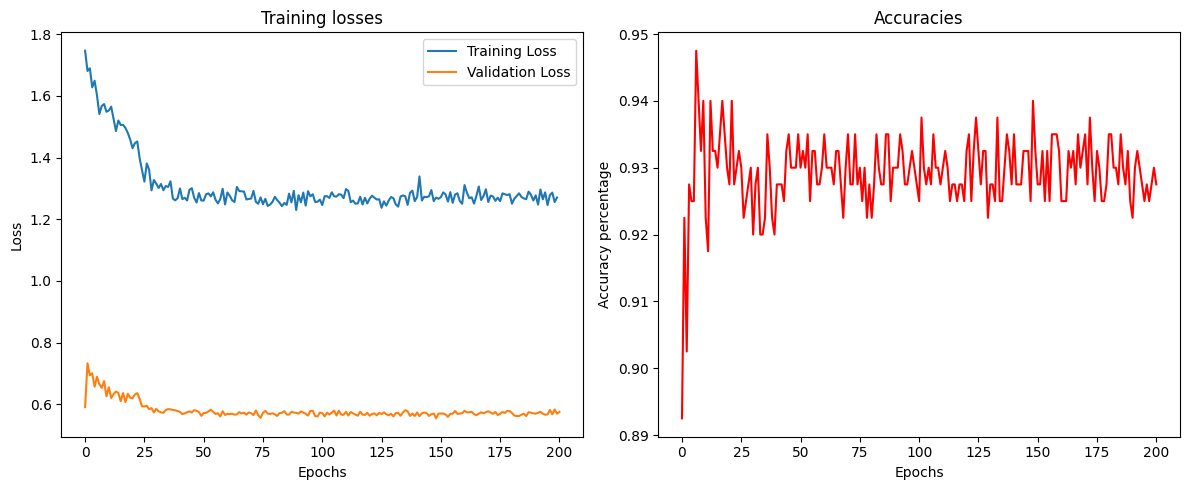

In [101]:
training_losses = np.array(checkpoint['training_losses'])
validation_losses = np.array(checkpoint['validation_losses'])
accuracies = np.array(checkpoint['accuracies'])

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Training loss
ax1.plot(range(len(training_losses)), training_losses, label='Training Loss')
ax1.plot(range(len(validation_losses)), validation_losses, label='Validation Loss')
ax1.set_title('Training losses')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Accuracies
ax2.plot(range(len(accuracies)), accuracies, color='red')
ax2.set_title('Accuracies')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy percentage')

plt.tight_layout()
plt.show()

# Inspect AE results

In [102]:
CLASS_NAMES = ['dog', 'rooster', 'pig', 'cow', 'frog', 'cat', 'hen', 'insects', 'sheep', 'crow', 'rain', 'sea waves', 'crackling fire', 'crickets', 'chirping birds', 'water drops', 'wind', 'Pouring water', 'Toilet flush', 'thunderstorm', 'baby crying', 'sneezing', 
               'clapping', 'breathing', 'coughing', 'footsteps', 'laughing', 'tooth brushing', 'snoring', 'drinking / sipping', 'knocking', 'mouse click', 'keyboard typing', 'creaks (door/wood)', 'can opening', 'washing machine', 'vacuum cleaner', 'alarm clock', 
               'ticking clock', 'glass breaking', 'helicopter', 'chainsaw', 'siren', 'car horn', 'engine', 'train', 'church bells', 'airplane', 'fireworks', 'hand saw']

In [124]:
AUDIO_FILE_INDEX = 15
waveform, target = test_dataset[AUDIO_FILE_INDEX]
waveform = torch.tensor(waveform)

print(waveform.shape)

print(CLASS_NAMES[target.argmax()])

torch.Size([2, 160000])
clapping


## Original audio wave

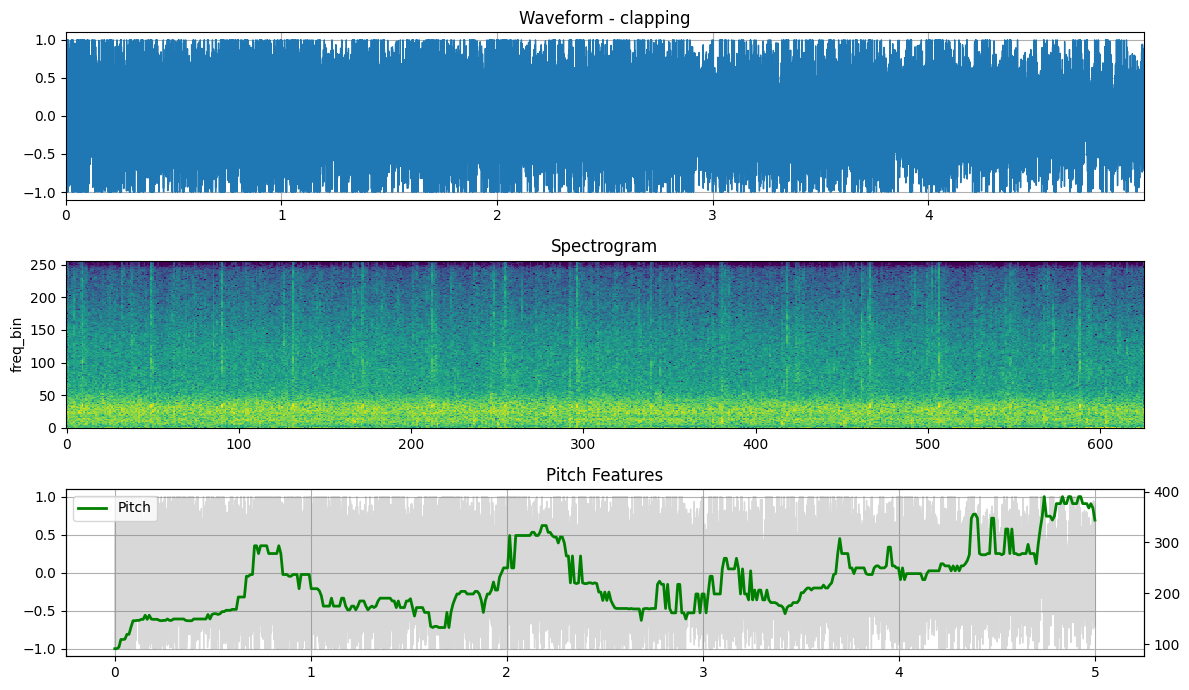

In [104]:
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
plot_waveform(waveform.mean(axis=0, keepdim=True), title=f'Waveform - {CLASS_NAMES[target.argmax()]}', ax=axs[0])
plot_spectrogram(waveform.mean(axis=0, keepdim=True), ax=axs[1])
plot_pitch(waveform.mean(axis=0, keepdim=True), ax=axs[2])
fig.tight_layout()

ipd.Audio(waveform.mean(axis=0, keepdim=True), rate=32_000)

## Base AE reconstruction

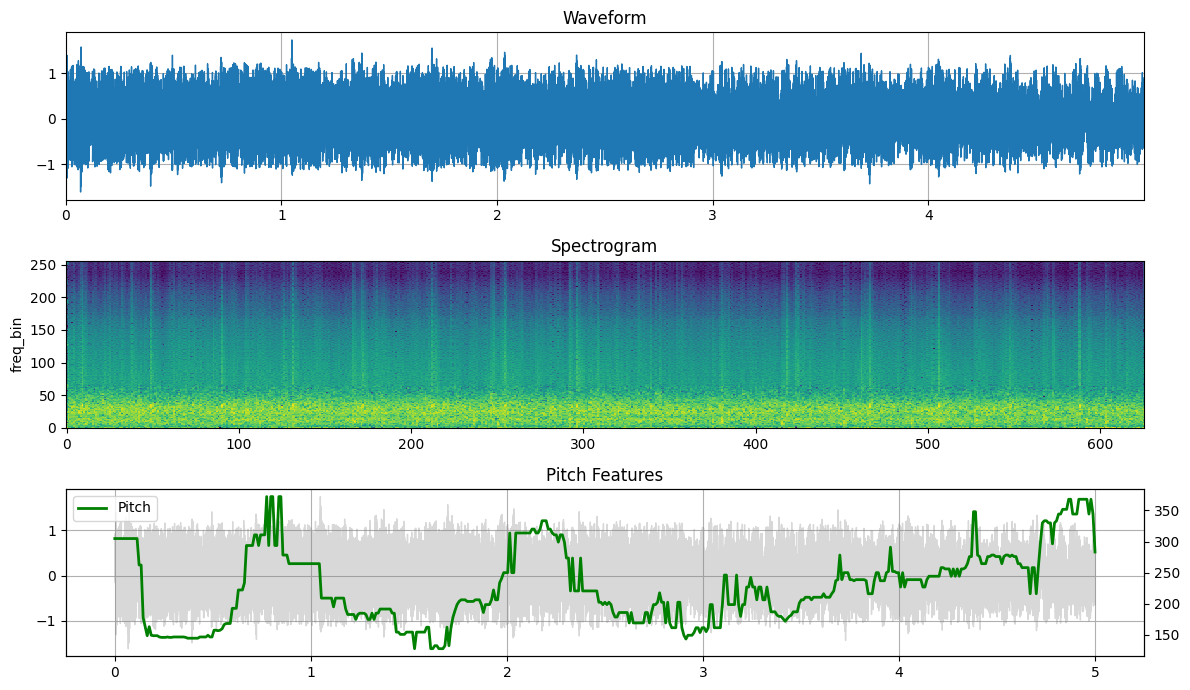

In [105]:
base_autoencoder = AudioAutoencoder(reduce_output=True).to(device)
base_reconstructed_waveform = base_autoencoder(waveform[None, :].to(device)).detach().cpu()[0]

fig, axs = plt.subplots(3, 1, figsize=(12, 7))
plot_waveform(base_reconstructed_waveform, ax=axs[0])
plot_spectrogram(base_reconstructed_waveform, ax=axs[1])
plot_pitch(base_reconstructed_waveform, ax=axs[2])
fig.tight_layout()

ipd.Audio(base_reconstructed_waveform, rate=32_000)

## Fine-tunde AE reconstruction

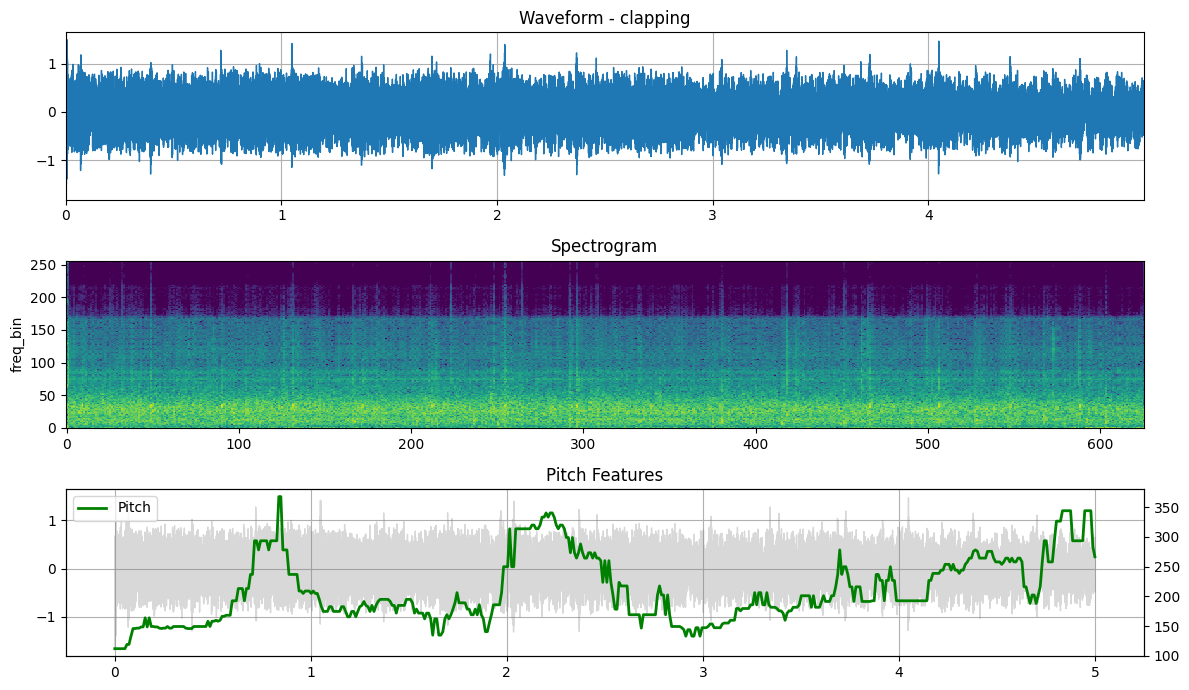

In [106]:
fine_reconstructed_waveform = pipeline.autoencoder(waveform[None,:].to(device)).detach().cpu()[0]
fine_predictions = pipeline(waveform[None,:].to(device)).detach().cpu()[0]

fig, axs = plt.subplots(3, 1, figsize=(12, 7))
plot_waveform(fine_reconstructed_waveform, title=f'Waveform - {CLASS_NAMES[fine_predictions.argmax()]}', ax=axs[0])
plot_spectrogram(fine_reconstructed_waveform, ax=axs[1])
plot_pitch(fine_reconstructed_waveform, ax=axs[2])
fig.tight_layout()

ipd.Audio(fine_reconstructed_waveform, rate=32_000)

## Difference in audio waveforms

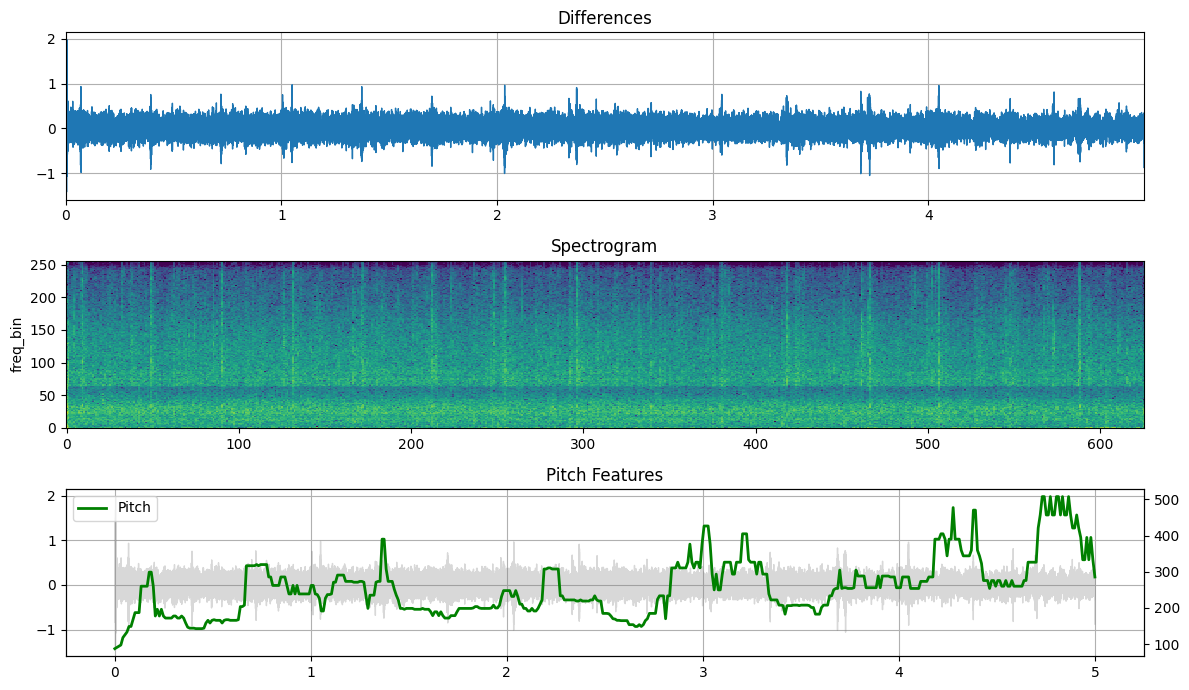

In [107]:
differences = waveform.mean(axis=0, keepdim=True) - fine_reconstructed_waveform

fig, axs = plt.subplots(3, 1, figsize=(12, 7))
plot_waveform(differences, title=f'Differences', ax=axs[0])
plot_spectrogram(differences, ax=axs[1])
plot_pitch(differences, ax=axs[2])
fig.tight_layout()

ipd.Audio(differences, rate=32_000)

## Compare spectrograms

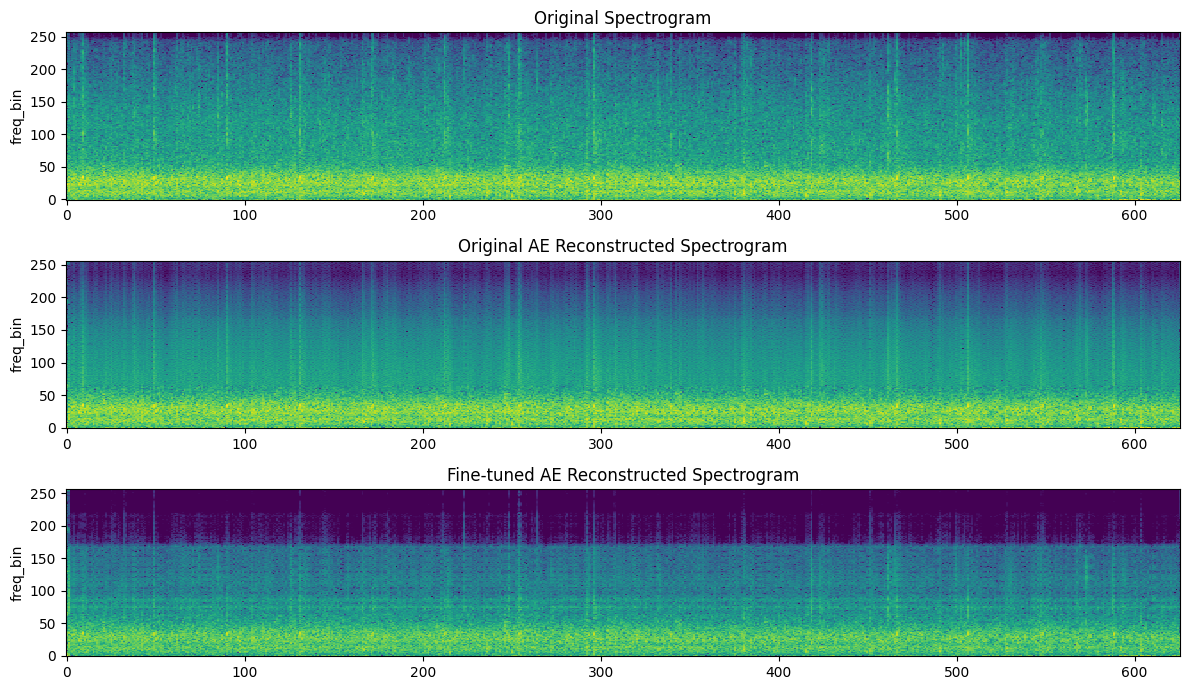

In [108]:
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
plot_spectrogram(waveform.mean(axis=0, keepdim=True), title='Original Spectrogram', ax=axs[0])
plot_spectrogram(base_reconstructed_waveform, title='Original AE Reconstructed Spectrogram', ax=axs[1])
plot_spectrogram(fine_reconstructed_waveform, title='Fine-tuned AE Reconstructed Spectrogram', ax=axs[2])
fig.tight_layout()

## Inspect Mel-Inputs to classifier

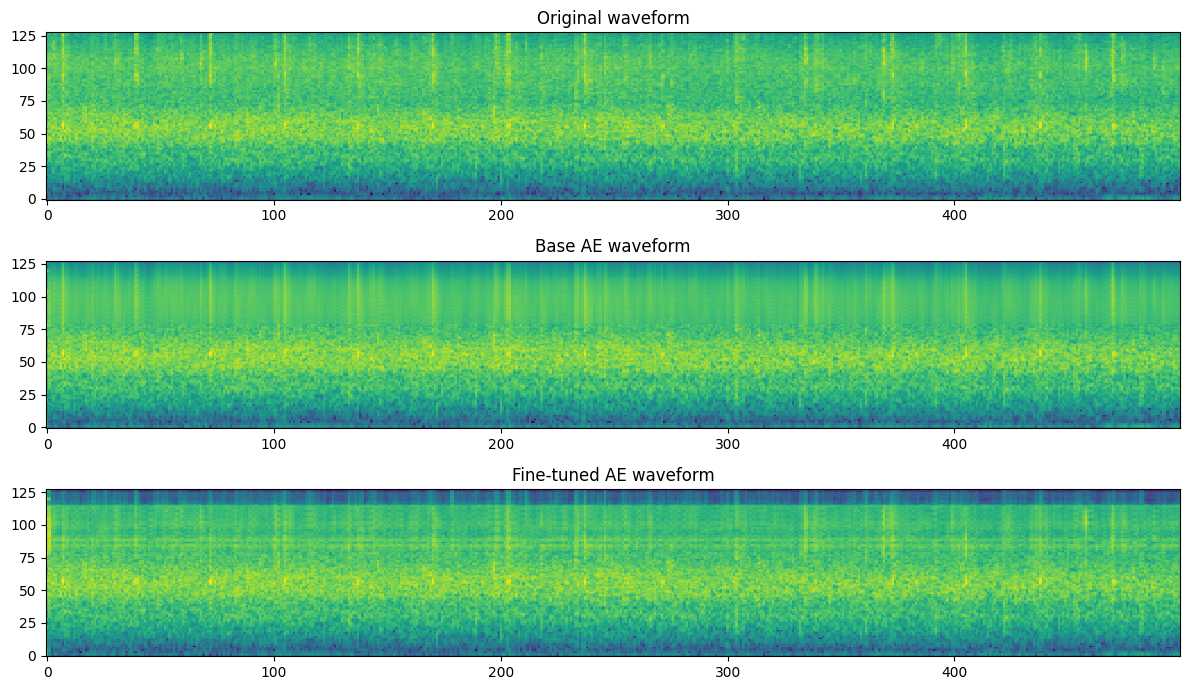

In [109]:
plain_mel_transformed = mel_transform(waveform.mean(axis=0, keepdim=True)[None, :].to(device)).detach().cpu()[0]
base_mel_transformed  = mel_transform(base_autoencoder(waveform[None, :].to(device))).detach().cpu()[0]
fine_mel_transformed  = mel_transform(pipeline.autoencoder(waveform[None, :].to(device))).detach().cpu()[0]

fig, axs = plt.subplots(3, 1, figsize=(12, 7))

axs[0].imshow(plain_mel_transformed[0], origin='lower', aspect='auto', interpolation='nearest')
axs[0].set_title('Original waveform')

axs[1].imshow(base_mel_transformed[0], origin='lower', aspect='auto', interpolation='nearest')
axs[1].set_title('Base AE waveform')

axs[2].imshow(fine_mel_transformed[0], origin='lower', aspect='auto', interpolation='nearest')
axs[2].set_title('Fine-tuned AE waveform')

fig.tight_layout()